In [1]:
import netCDF4 as nc
import os
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Reading file with points coordinates

In [2]:
points_ds=pd.read_csv('./grid_of_points(10x2).csv', sep=',')
points_ds

,id,x,y
0,1,8.72,76.04
1,2,8.72,75.84
2,3,8.72,75.64
3,4,8.72,75.44
4,5,9.72,76.44
...,...,...,...
272,274,31.72,77.04
273,275,31.72,76.84
274,276,31.72,76.64
275,277,31.72,76.44


## Function for extracting values by coordinates

In [3]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    dif=np.abs(coord_array-coordinate)
    dis=np.sum(dif, axis=2)
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

## Creating time series for ARCTIC reanalysis dataset

In [5]:
nc_file = 'C:/Users/Julia/Documents/ITMO/ITMO_master_degree_classes/Research_work(NEMO)/arctic-ssh-y2002.nc'
ds = nc.Dataset(nc_file)

In [6]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
#print(names_dict)

for j in range(365):  
    sea_level=np.array(ds['ssh'])[j]
    for i in range (len(coordinates_from_map['lat'])):       
        #print('Day: '+str(j)+'Point: '+str(i))        

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = ds.variables['latitude'][:]
        lons = ds.variables['longitude'][:]

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
#names_dict

In [7]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='31-12-2002', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./data_time_series/2002_ARCTIC_reanalysis_GRID.csv', sep=';', index=False)
pd_df

,76.04_8.72,75.84_8.72,75.64_8.72,75.44_8.72,76.44_9.72,76.24_9.72,76.04_9.72,75.84_9.72,75.64_9.72,75.44_9.72,...,76.84_30.72,76.64_30.72,76.44_30.72,76.24_30.72,77.04_31.72,76.84_31.72,76.64_31.72,76.44_31.72,76.84_32.72,dates
0,-0.514026,-0.515261,-0.516009,-0.507082,-0.504714,-0.506331,-0.507329,-0.507026,-0.506257,-0.504071,...,-0.466387,-0.467167,-0.464832,-0.464832,-0.459716,-0.464722,-0.470688,-0.470122,-0.467363,2002-01-01
1,-0.489136,-0.489905,-0.490766,-0.482878,-0.479015,-0.480923,-0.480595,-0.480320,-0.479774,-0.477917,...,-0.397489,-0.397711,-0.393654,-0.393654,-0.386779,-0.385702,-0.389440,-0.388129,-0.383589,2002-01-02
2,-0.479917,-0.480635,-0.481603,-0.473776,-0.470219,-0.471974,-0.470476,-0.470214,-0.469766,-0.467735,...,-0.414249,-0.422216,-0.431802,-0.431802,-0.398815,-0.403768,-0.418549,-0.425269,-0.416425,2002-01-03
3,-0.464741,-0.465282,-0.466064,-0.458172,-0.455844,-0.457293,-0.454120,-0.453899,-0.453569,-0.451797,...,-0.454798,-0.456824,-0.451600,-0.451600,-0.452358,-0.455313,-0.458175,-0.456769,-0.455870,2002-01-04
4,-0.471832,-0.472478,-0.473560,-0.467324,-0.464111,-0.465617,-0.463902,-0.463887,-0.463729,-0.463607,...,-0.417114,-0.414506,-0.409456,-0.409456,-0.413606,-0.405627,-0.405894,-0.403097,-0.400696,2002-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-0.492056,-0.499308,-0.509579,-0.497058,-0.472869,-0.473256,-0.475143,-0.481787,-0.486860,-0.475467,...,-0.337861,-0.337925,-0.326738,-0.326738,-0.333726,-0.340791,-0.345907,-0.340394,-0.362003,2002-12-27
361,-0.493447,-0.500768,-0.509778,-0.496599,-0.475878,-0.475752,-0.477817,-0.484504,-0.489610,-0.477847,...,-0.368982,-0.367491,-0.353319,-0.353319,-0.366919,-0.372422,-0.374853,-0.369487,-0.384619,2002-12-28
362,-0.488364,-0.495617,-0.503469,-0.489825,-0.470997,-0.470725,-0.473053,-0.479672,-0.484616,-0.471987,...,-0.378845,-0.376277,-0.361715,-0.361715,-0.373679,-0.375883,-0.380451,-0.376854,-0.384335,2002-12-29
363,-0.479422,-0.487205,-0.495123,-0.481621,-0.458476,-0.458770,-0.462646,-0.469849,-0.475197,-0.462204,...,-0.365876,-0.362276,-0.348200,-0.348200,-0.359182,-0.359662,-0.365231,-0.361427,-0.368278,2002-12-30


### Checking is there gaps

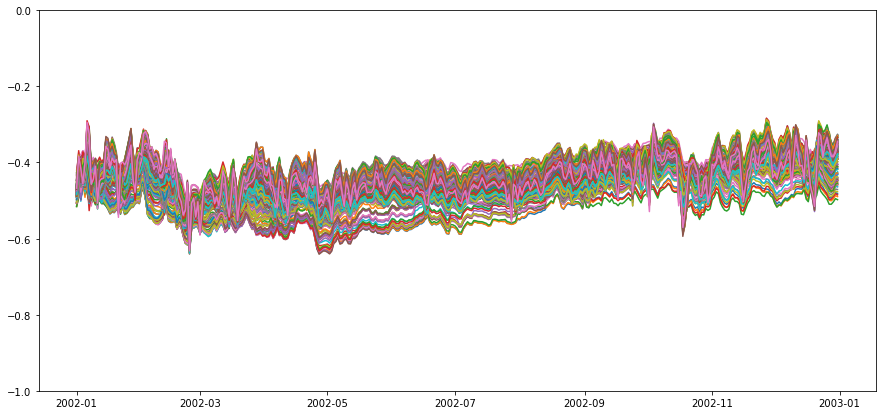

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)
plt.ylim(-1, 0)
#plt.legend()
plt.show()

## Creating time series for NEMO_SPITZ dataset

In [9]:
nemo_data_folder='C:/Users/Julia/Documents/ITMO/ITMO_master_degree_classes/Research_work(NEMO)/dataset_SPITZ12'

In [11]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
    
for file in os.listdir(nemo_data_folder):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(nemo_data_folder, file))
    except Exception as e:
        print(e)
        pass
            
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['zos'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = np.array(ds['nav_lat'])
        lons = np.array(ds['nav_lon'])

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)

[Errno -51] NetCDF: Unknown file format: b'C:/Users/Julia/Documents/ITMO/ITMO_master_degree_classes/Research_work(NEMO)/dataset_SPITZ12\\SPITZ_1d_00010101_00011231_grid_T_00010101-00010101.nc.aux.xml'


In [12]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='1-1-2003', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./data_time_series/2002_NEMO_SPITZ_GRID.csv', sep=';', index=False)
pd_df

,76.04_8.72,75.84_8.72,75.64_8.72,75.44_8.72,76.44_9.72,76.24_9.72,76.04_9.72,75.84_9.72,75.64_9.72,75.44_9.72,...,76.84_30.72,76.64_30.72,76.44_30.72,76.24_30.72,77.04_31.72,76.84_31.72,76.64_31.72,76.44_31.72,76.84_32.72,dates
0,-0.942993,-0.937628,-0.930204,-0.926181,-0.949348,-0.954056,-0.942295,-0.939654,-0.938162,-0.943516,...,-0.865533,-0.880952,-0.885008,-0.887473,-0.855233,-0.856440,-0.861575,-0.875327,-0.857126,2002-01-01
1,-0.942993,-0.937628,-0.930204,-0.926181,-0.949348,-0.954056,-0.942295,-0.939654,-0.938162,-0.943516,...,-0.865533,-0.880952,-0.885008,-0.887473,-0.855233,-0.856440,-0.861575,-0.875327,-0.857126,2002-01-02
2,-0.954143,-0.949737,-0.943272,-0.941566,-0.963461,-0.964639,-0.952621,-0.951219,-0.952585,-0.960035,...,-0.876808,-0.891283,-0.896531,-0.900448,-0.870082,-0.876918,-0.881961,-0.893854,-0.881724,2002-01-03
3,-0.931632,-0.929046,-0.923890,-0.923869,-0.941948,-0.942619,-0.934764,-0.935740,-0.937847,-0.943613,...,-0.896532,-0.908186,-0.911249,-0.913017,-0.889516,-0.898641,-0.898054,-0.906221,-0.893768,2002-01-04
4,-0.916045,-0.914592,-0.909500,-0.909975,-0.932103,-0.931216,-0.922982,-0.923508,-0.924925,-0.927923,...,-0.882398,-0.890130,-0.889501,-0.890809,-0.876646,-0.878063,-0.878136,-0.886778,-0.869840,2002-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-0.926950,-0.936539,-0.923194,-0.904722,-0.943568,-0.933682,-0.917024,-0.907105,-0.900654,-0.908947,...,-0.778285,-0.773105,-0.771124,-0.771343,-0.785147,-0.780579,-0.772303,-0.773564,-0.795469,2002-12-28
362,-0.938924,-0.949687,-0.938435,-0.915860,-0.955742,-0.947546,-0.927565,-0.920571,-0.912849,-0.920480,...,-0.782651,-0.777705,-0.774124,-0.773126,-0.789242,-0.785402,-0.777304,-0.777887,-0.799299,2002-12-29
363,-0.949362,-0.961301,-0.950975,-0.923545,-0.966302,-0.959826,-0.937372,-0.934917,-0.924476,-0.930004,...,-0.781056,-0.776708,-0.772152,-0.770868,-0.786105,-0.781754,-0.774197,-0.775878,-0.793030,2002-12-30
364,-0.957105,-0.970395,-0.961219,-0.931276,-0.973440,-0.968722,-0.946500,-0.949262,-0.935017,-0.937616,...,-0.779540,-0.778097,-0.775524,-0.776043,-0.782384,-0.778408,-0.773417,-0.779315,-0.788577,2002-12-31


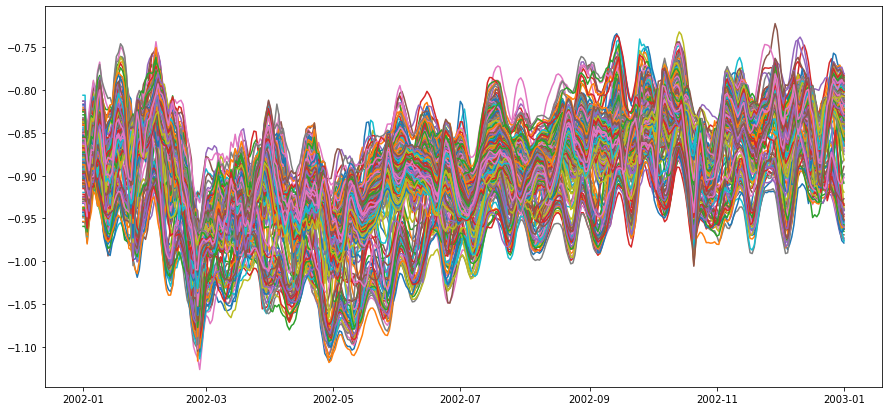

In [13]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)

#plt.legend()
plt.show()